In [2]:
import numpy as np
import pandas as pd
import torch
import pingouin as pg
from tqdm import tqdm
from nilearn import datasets
from nilearn import plotting
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from scipy.spatial.distance import correlation
from torch.utils.data import DataLoader, Dataset, Subset
from nilearn.connectome import sym_matrix_to_vec
from sklearn.manifold import TSNE
from contrastive_phenotypes.src.ContModeling.helper_classes import MatData
from contrastive_phenotypes.src.ContModeling.models import PhenoProj
#from hydra import initialize, compose
from omegaconf import DictConfig, OmegaConf
import xarray as xr
from neuromaps.datasets import fetch_fslr
from brainspace.utils.parcellation import map_to_labels, reduce_by_labels
from brainspace.datasets import load_conte69, load_parcellation
from brainspace.plotting import plot_hemispheres
from surfplot import Plot
from statsmodels.robust.scale import Huber
from scipy.stats import trim_mean
from neuromaps.datasets import fetch_fslr
from brainspace.utils.parcellation import map_to_labels
from surfplot import Plot


/storage/store2/work/mrenaudi/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
mape_mat = np.load('results/final model run 5 : seed 87/recon_mat/mape_mat_run0.npy')

In [4]:
mape_mat.shape

(106, 400, 400)

In [5]:
mape_mat[0]

array([[1.22870979e+01, 1.33925939e+00, 2.21906223e+01, ...,
        3.49378052e+01, 1.78766266e+02, 1.08814980e+02],
       [1.33922553e+00, 5.39136505e+00, 2.34444260e+02, ...,
        2.33111620e+00, 2.54228561e+02, 8.52456951e+00],
       [2.21906223e+01, 2.34444397e+02, 9.00897980e+00, ...,
        1.49531436e+04, 1.60130829e+02, 4.68485336e+01],
       ...,
       [3.49378967e+01, 2.33118796e+00, 1.49531680e+04, ...,
        3.56611862e+01, 2.43959789e+01, 2.41537647e+01],
       [1.78766174e+02, 2.54228928e+02, 1.60130829e+02, ...,
        2.43959656e+01, 1.64980888e+00, 1.60482006e+01],
       [1.08815254e+02, 8.52453804e+00, 4.68484879e+01, ...,
        2.41537704e+01, 1.60481892e+01, 1.32641315e+01]], dtype=float32)

In [6]:
count_greater_than_1 = np.sum(mape_mat > 100)

# Total number of elements in mape_mat
total_elements = mape_mat.size

# Proportion of values greater than 1
proportion_greater_than_1 = count_greater_than_1 / total_elements

# Print the result
print(f"Proportion of values greater than 1: {proportion_greater_than_1:.4f}")

Proportion of values greater than 1: 0.1997


In [7]:
huber_estimator = Huber(maxiter = 5000)

In [8]:
robust_mean_mape_mat = np.empty((400, 400))
# for i in range(400):
#     for j in range(400):
#         robust_mean_mape_mat[i, j], _ = huber_estimator(mape_mat[:, i, j])
# robust_mean_mape_mat = np.empty((400, 400))

#Compute the mean along the 0th dimension for each element
# for i in range(400):
#     for j in range(400):
#         robust_mean_mape_mat[i, j] = np.median(mape_mat[:, i, j])
robust_mean_mape_mat = np.empty((400, 400))
for i in range(400):
    for j in range(400):
        robust_mean_mape_mat[i, j] = trim_mean(mape_mat[:, i, j], proportiontocut=0.1)


#np.save(f'./abstract_viz/robust_mape.npy', robust_mean_mape_mat)


Text(-9, 0.02, 'Median Mean MAPE = 53.06')

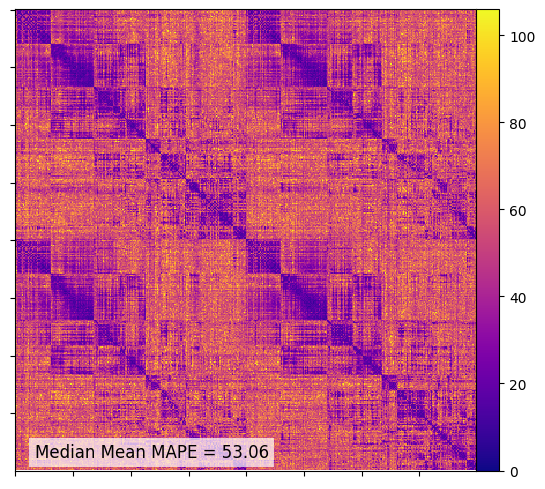

In [9]:
plotting.plot_matrix(robust_mean_mape_mat,
                     grid = False,
                     vmin = 0,
                     vmax = 106,
                     cmap='plasma'
    )
# Calculate the mean correlation value
median_mean_mape = np.median(robust_mean_mape_mat)
# Add text annotation for the mean correlation value
plt.text(-9, 0.02, f'Median Mean MAPE = {median_mean_mape:.2f}', color='black', ha='right', va='bottom', fontsize=12, transform=plt.gca().transAxes,
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

#plt.savefig(f"./abstract_viz/robust_mean_mape_mat.svg", format = "svg", dpi = 300, bbox_inches='tight')

## Plot on surface

ValueError: The surf_map does not have the same number of vertices as the mesh.

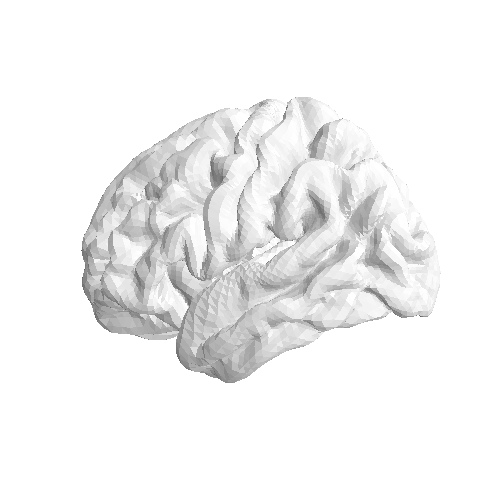

In [16]:
from nilearn.plotting import plot_surf, plot_surf_stat_map

atlas = datasets.fetch_atlas_schaefer_2018(n_rois=400, resolution_mm=2)
stat_map = robust_mean_mape_mat.mean(axis=1)
fsaverage = datasets.fetch_surf_fsaverage()
plot_surf_stat_map(
    fsaverage['pial_left'], 
    stat_map[:200],  # First 200 regions for the left hemisphere
    title='Left Hemisphere Connectivity',
    hemi='left',  # Specify the hemisphere
    colorbar=True
)

plot_surf._tat_map(
    fsaverage['pial_right'],
    stat_map[200:],  # Last 200 regions for the right hemisphere
    title='Right Hemisphere Connectivity',
    hemi='right',
    colorbar=True
)

In [20]:
from nilearn import datasets
from nilearn import surface

# Fetch the fsaverage brain surface
fsaverage = datasets.fetch_surf_fsaverage()

# Load the right hemisphere surface mesh
right_hemisphere_surface = surface.load_surf_mesh(fsaverage['pial_right'])

# Get the number of vertices in the right hemisphere
right_hemisphere_vertices = right_hemisphere_surface.coordinates.shape[0]
print(f"Number of vertices in the right hemisphere: {right_hemisphere_vertices}")



Number of vertices in the right hemisphere: 10242


In [26]:


surfaces = fetch_fslr()
lh, rh = surfaces['veryinflated']
lh_parc, rh_parc = load_parcellation('schaefer', 400)
schaefer_labels_400 = load_parcellation('schaefer', scale=400, join=True)

mean_val = robust_mean_mape_mat.mean(axis=1)

deg_centrality_diff = map_to_labels(mean_val, schaefer_labels_400, mask=schaefer_labels_400 != 0, fill=np.nan)
print(deg_centrality_diff.shape)
lh, rh = surfaces['veryinflated']

degree_plot = Plot(lh, rh, size=(200, 400), brightness=1, views=['lateral'])#, 'posterior', 'medial'])

degree_plot.add_layer({'left': deg_centrality_diff[:32492], 'right': deg_centrality_diff[32492:]}, cbar=True, cmap="viridis",  zero_transparent=False, alpha=1, color_range = (0, 100)) 

fig = degree_plot.build()
fig.axes[0].set_title(f'blablabla', pad=-3)
#fig.savefig(f"../../figures/cortex_regions/degree_centrality_diff_{n}.svg", format = "svg", dpi = 300, bbox_inches='tight')

: 

In [15]:
import numpy as np
from nilearn import plotting
import numpy as np

# Fetch surfaces
surfaces = fetch_fslr()
lh, rh = surfaces['veryinflated']

# Load parcellation
lh_parc, rh_parc = load_parcellation('schaefer', 400)
schaefer_labels_400 = load_parcellation('schaefer', scale=400, join=True)

# Ensure mean_val is a NumPy array of floats
mean_val = np.asarray(robust_mean_mape_mat.mean(axis=1), dtype=float)

# Ensure the mapping works with the correct data type
deg_centrality_diff = map_to_labels(
    mean_val, 
    schaefer_labels_400, 
    mask=schaefer_labels_400 != 0, 
    fill=np.nan
)

# Visualization

degree_plot = Plot(lh, rh, size=(200, 400), brightness=1, views=['lateral'])
degree_plot.add_layer(
    {'left': deg_centrality_diff[:32492], 'right': deg_centrality_diff[32492:]}, 
    cbar=True, 
    cmap="viridis", 
    zero_transparent=False, 
    alpha=1, 
    color_range=(float(np.nanmin(deg_centrality_diff)), float(np.nanmax(deg_centrality_diff)))
)

fig = degree_plot.build()
fig.axes[0].set_title('Degree Centrality Difference', pad=-3)

: 

## Correlation

In [10]:
dataset = xr.open_dataset("dataset_400parcels_2.nc")
test_idx = np.load('results/pretraining mat with embeddings 200 and 200 epochs/test_idx.npy')
true_mat = dataset.matrices.isel(subject = test_idx).values

In [247]:
test_idx.shape

(106,)

In [11]:
recon_mat = np.load('results/final model run 5 : seed 87/recon_mat/recon_mat_run0.npy')

In [205]:
32*3+10

106

In [12]:
def compute_batch_elementwise_correlation(true, recon):
    batch_size, rows, cols = true.shape
    correlations = np.zeros((rows, cols))

    flat_true = true.reshape(batch_size, -1)
    flat_recon = recon.reshape(batch_size, -1)
    
    for i in range(rows * cols):
        correlations[i // cols, i % cols] = spearmanr(flat_true[:, i], flat_recon[:, i])[0]
        
    np.fill_diagonal(correlations, 1.0)

    return correlations

In [207]:
batch_1 = np.load('results/pretraining mat with embeddings 200 and 200 epochs/recon_mat/recon_mat_fold2_batch_1.npy')
batch_2 = np.load('results/pretraining mat with embeddings 200 and 200 epochs/recon_mat/recon_mat_fold2_batch_2.npy')
batch_3 = np.load('results/pretraining mat with embeddings 200 and 200 epochs/recon_mat/recon_mat_fold2_batch_3.npy')
batch_4 = np.load('results/pretraining mat with embeddings 200 and 200 epochs/recon_mat/recon_mat_fold2_batch_4.npy')

# Stack them along a new axis (axis=0 means stacking along the first dimension, adding a new dimension)
recon_mat = np.concatenate([batch_1, batch_2, batch_3, batch_4], axis=0)


In [13]:
mat_corr = compute_batch_elementwise_correlation(true_mat, recon_mat)

/tmp/ipykernel_26843/4045408121.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlations[i // cols, i % cols] = spearmanr(flat_true[:, i], flat_recon[:, i])[0]


In [14]:
np.save(f'./abstract_viz/corr.npy', mat_corr)

Text(-14, 0.02, 'Mean r = 0.87')

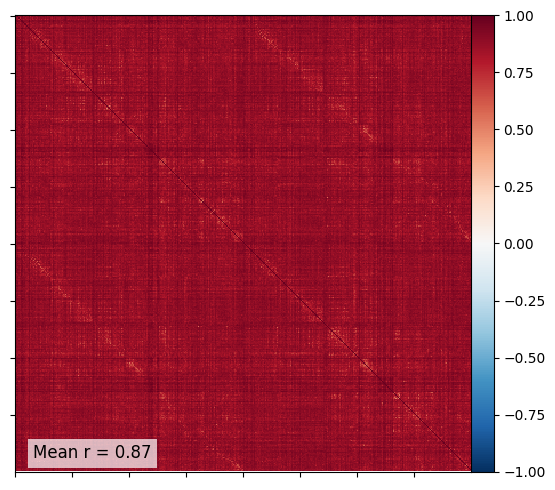

In [266]:
plotting.plot_matrix(mat_corr,
    # title=f"Corr(True, Recon)",
                     grid = False,
                     vmax = 1.,
                     vmin = -1.
    )
# Calculate the mean correlation value
mean_corr = mat_corr.mean()
# Add text annotation for the mean correlation value
plt.text(-14, 0.02, f'Mean r = {mean_corr:.2f}', color='black', ha='right', va='bottom', fontsize=12, transform=plt.gca().transAxes,
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))